# Playlist Breakdown

In 'Playlist_to_CSV', we used the spotipy Python library to access Spotify's Web API to extract data from our playlist. We stored that data in a CSV file, which we will import and analyze. Our goal is to break this large playlist down into smaller, more cohesive playlists. Instead of doing this subjectively, which would take a very long time, we can approach the problem mathematically and use data science to speed up the process.

### Data Loading and Exploration

In [34]:
#import necessary libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
#read in data from csv file
input_file = 'data/playlist_info.csv'
playlist = pd.read_csv(input_file)

In [19]:
#print general info
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              808 non-null    object 
 1   artist            808 non-null    object 
 2   album             808 non-null    object 
 3   release_date      808 non-null    object 
 4   popularity        808 non-null    int64  
 5   danceability      808 non-null    float64
 6   energy            808 non-null    float64
 7   key               808 non-null    int64  
 8   loudness          808 non-null    float64
 9   mode              808 non-null    int64  
 10  speechiness       808 non-null    float64
 11  acousticness      808 non-null    float64
 12  instrumentalness  808 non-null    float64
 13  liveness          808 non-null    float64
 14  valence           808 non-null    float64
 15  tempo             808 non-null    float64
 16  duration_ms       808 non-null    int64  
 1

There are 808 rows, 18 columns, and 0 null values. Each row corresponds to one song, and each column corresponds to a specific attribute of a song. To get a better understanding of each of these attributes, take a look at the Spotify audio feature documentation:  
https://developer.spotify.com/documentation/web-api/reference/get-audio-features  

The first few rows of data are shown below.

In [20]:
#print first few rows
playlist.head()

,name,artist,album,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,A Sky Full of Stars,Coldplay,Ghost Stories,2014-05-19,89,0.545,0.675,6,-6.474,1,0.0279,0.00617,0.001970,0.209,0.162,124.970,267867,4
1,Apple Pie,Travis Scott,Rodeo,2015-09-04,71,0.655,0.496,3,-4.139,0,0.0364,0.03350,0.000000,0.156,0.280,137.945,219360,4
2,Still Dreaming,Nas,Hip Hop Is Dead (Expanded Edition),2007-01-23,64,0.547,0.825,7,-8.499,1,0.2120,0.10500,0.000248,0.140,0.589,119.743,217827,5
3,That Go! (feat. T-Shyne),Young Stoner Life,Slime Language 2,2021-04-16,54,0.713,0.575,1,-6.706,1,0.0501,0.00669,0.000000,0.169,0.189,145.950,226400,4
4,THank god 4 me,ScHoolboy Q,BLUE LIPS,2024-03-01,35,0.721,0.566,2,-7.871,1,0.1960,0.65200,0.000000,0.112,0.415,136.017,177261,4


Let's see a statistical overview of the contents of each of the numerical columns.

In [21]:
#print statistical description
playlist.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,808.000000,808.000000,808.00000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000
mean,67.490099,0.662236,0.65145,5.387376,-6.575170,0.497525,0.151189,0.173833,0.033929,0.203068,0.455836,123.768016,224553.897277,3.976485
std,20.178507,0.151483,0.15472,3.688246,2.362599,0.500304,0.123423,0.207158,0.151980,0.157545,0.230555,30.210326,62894.978018,0.299841
min,0.000000,0.079800,0.07920,0.000000,-20.652000,0.000000,0.024600,0.000004,0.000000,0.034400,0.038600,61.311000,62253.000000,1.000000
25%,63.000000,0.566000,0.55275,1.000000,-7.626000,0.000000,0.047825,0.023200,0.000000,0.103000,0.279250,97.064000,183732.000000,4.000000
50%,73.000000,0.680500,0.65800,6.000000,-6.361000,0.000000,0.099350,0.090800,0.000000,0.139500,0.440500,123.103500,218342.500000,4.000000
75%,80.000000,0.773000,0.76400,9.000000,-5.075500,1.000000,0.238000,0.248000,0.000108,0.267000,0.622250,146.041500,256002.000000,4.000000
max,97.000000,0.974000,0.98300,11.000000,0.290000,1.000000,0.649000,0.976000,0.982000,0.972000,0.969000,205.846000,760973.000000,5.000000


Although `key`, `mode`, and `time_signature` are included here, they are categorical variables which we will deal with in the Data Preprocessing section.  

Let's see how each numerical variable relates to one another with a heatmap.

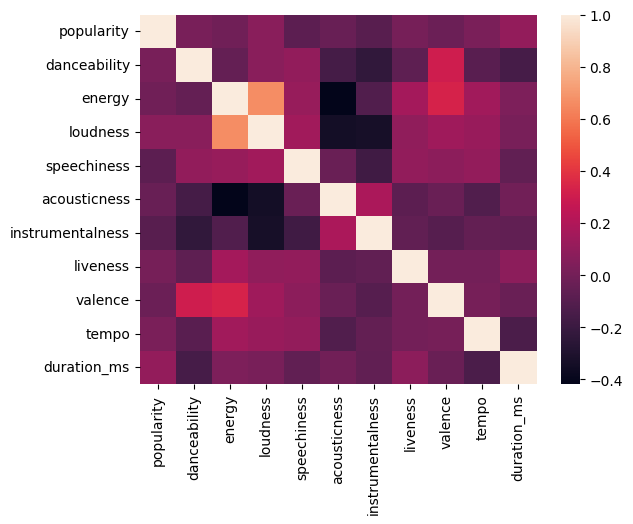

In [22]:
#create a heatmap of correlation matrix
sns.heatmap(playlist.drop(['name', 'artist', 'album', 'release_date', 'key', 'mode', 'time_signature'], axis = 1).corr())
plt.show()

The most positively correlated variables are `energy` and `loudness`, which makes sense intuitively. The most negatively correlated variables are `energy` and `acousticness`.

### Data Preprocessing

Columns like `name`, `artist`, `album`, `release_date`, and `popularity` are irrelevant for our model because they don't provide information about the audio features of a song.

Let's take a look at the `time_signature` column.

In [23]:
#view value distribution of column in question
playlist['time_signature'].value_counts(normalize=True)

time_signature
4    0.949257
3    0.027228
5    0.018564
1    0.004950
Name: proportion, dtype: float64

We will also drop `time_signature` because of its extremely low variance, having almost 95% of its values being equal.  

Although `key` does not have low variance like `time_signature`, what matters most in terms of feel about a song's key is whether it is major or minor, which is already stored in `mode`. Therefore we can drop `key` as well.

The only non-numerical column is `mode`. However, as mentioned previously, `mode` only has two categories, 1 representing 'major' and 0 representing 'minor'. Since it is already binary, we can leave it as is.

In [24]:
#drop unnecessary columns
playlist_audio_features = playlist.drop(columns=['name', 'artist', 'album', 'release_date', 'popularity', 'key', 'duration_ms', 'time_signature'])

#print first few rows
playlist_audio_features.head()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.545,0.675,-6.474,1,0.0279,0.00617,0.001970,0.209,0.162,124.970
1,0.655,0.496,-4.139,0,0.0364,0.03350,0.000000,0.156,0.280,137.945
2,0.547,0.825,-8.499,1,0.2120,0.10500,0.000248,0.140,0.589,119.743
3,0.713,0.575,-6.706,1,0.0501,0.00669,0.000000,0.169,0.189,145.950
4,0.721,0.566,-7.871,1,0.1960,0.65200,0.000000,0.112,0.415,136.017


Our data is almost ready for model fitting! There are no missing values to impute. We just have to scale numerical variables. Thanks to Spotify's Web API, most of the numerical variables are already in a usable format. We will scale the ones that are not to match that format using MinMaxScaler. To streamline this, let's create a pipeline.

In [25]:
#define type of scaling
scaler = Pipeline(steps=[('scale',  StandardScaler())])

#define columns that need to be transformed
transform_cols = playlist_audio_features.columns.drop('mode')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, transform_cols)
    ], remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the pipeline to your dataset
X = pipeline.fit_transform(playlist_audio_features)

In [26]:
X[0]

array([-0.77440445,  0.15230821,  0.04284781, -0.99953876, -0.80984954,
       -0.21041178,  0.03767885, -1.27526211,  0.03981183,  1.        ])

Above, we can see the first entry of our preprocessed data. The first 2 values are the scaled numerical values, `loudness` and `tempo`. The next 8 values are the columns we did not touch. We are now ready for model fitting.

### Model Fitting

Before we fit a KMeans model, let's find the optimal value for k using the elbow method.

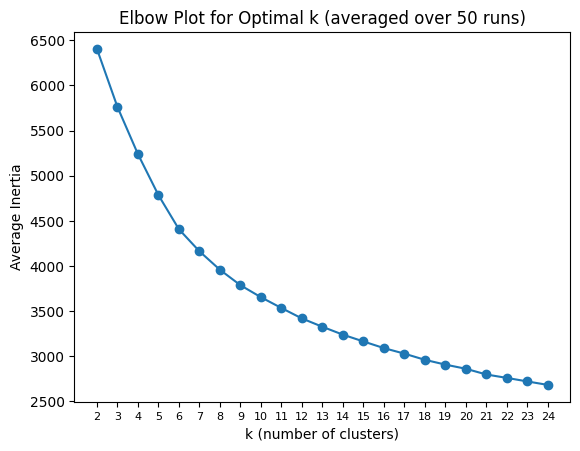

In [27]:
def elbowPlot(data, max_k=25, n_runs=50):
    avg_inertia = []
    for k in range(2, max_k):
        inertia = []
        for _ in range(n_runs):
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(data)
            inertia.append(kmeans.inertia_)
        avg_inertia.append(np.mean(inertia))
    
    plt.plot(range(2, max_k), avg_inertia, marker='o')
    plt.xticks(range(2, max_k), fontsize=8)
    plt.xlabel('k (number of clusters)')
    plt.ylabel('Average Inertia')
    plt.title(f'Elbow Plot for Optimal k (averaged over {n_runs} runs)')
    plt.show()

elbowPlot(X)

Unfortunately, this plot doesn't help as much as we'd like it to. It seems like the elbow falls somewhere between k=6 and k=9, but there is no standout value for k. Let's plot cluster distributions for k between 6 and 9.

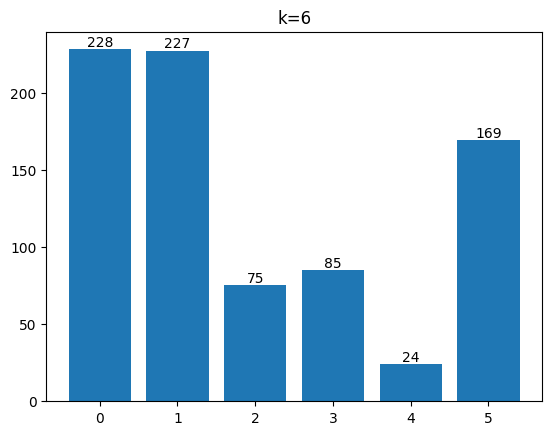

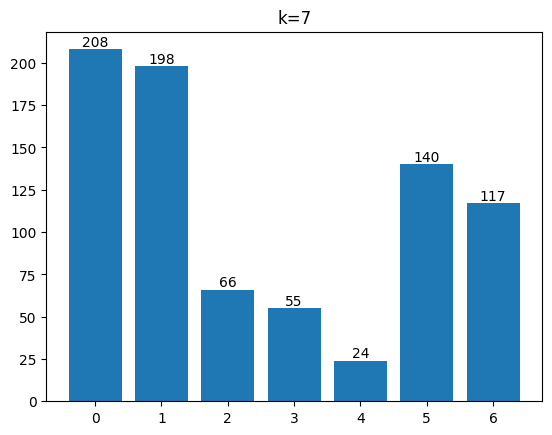

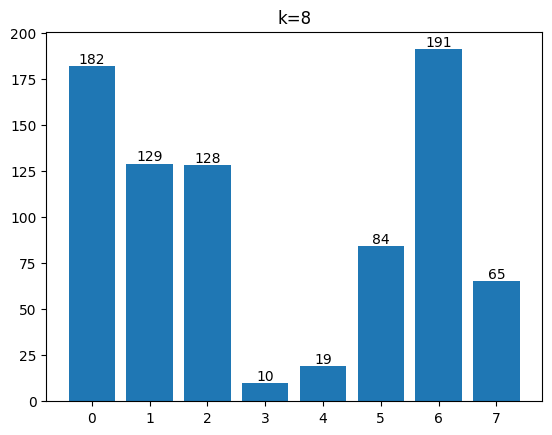

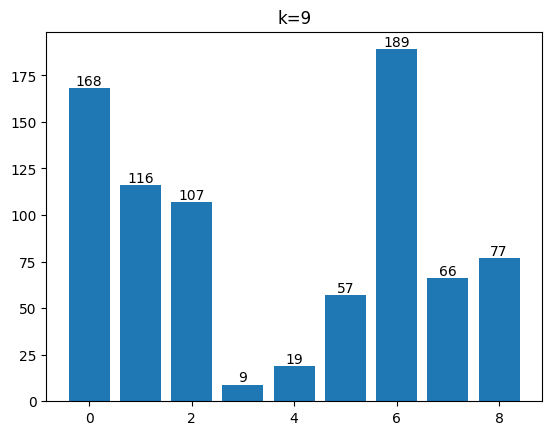

In [28]:
for i in range(6,10):
    kmeans = KMeans(n_clusters = i, random_state=42)
    unique, counts = np.unique(kmeans.fit(X).labels_, return_counts=True)
    clust_groups = plt.bar(unique, counts)
    plt.bar_label(clust_groups)
    plt.title(f'k={i}')
    plt.show()

All of the values of k above 7 have at least one cluster with 10 or less points. In this context, that means we will have one or more playlists with 10 or fewer songs, which would not be considered a complete playlist. For k values 6 and 7, the smallest cluster has 24 points. To be honest, a playlist with 24 songs doesn't feel complete either, but before we start criticizing the algorithm, let's explore why it is grouping these particular songs. Going forward, we will select 6 as our k value since the next smallest clusters are larger.

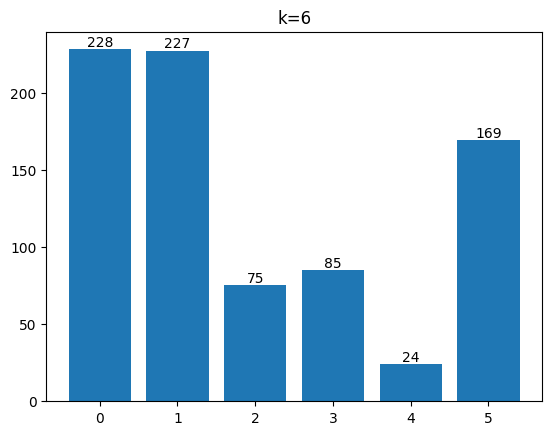

In [29]:
k=6
kmeans = KMeans(n_clusters = k, random_state=42)
X_grouped = kmeans.fit(X)

unique, counts = np.unique(X_grouped.labels_, return_counts=True)
clust_groups = plt.bar(unique, counts)
plt.bar_label(clust_groups)
plt.title('k=6')
plt.show()

*Note: This is the exact same as the previous k=6 because we did not change the seed.  

Let's look at the average attribute values of songs in each cluster.

In [30]:
playlist_grouped = playlist
playlist_grouped['cluster'] = X_grouped.labels_
playlist_grouped.groupby('cluster').mean(numeric_only=True).drop(columns = ['popularity', 'key', 'duration_ms', 'time_signature'])

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,,
0,0.740947,0.728855,-5.631719,0.456140,0.142214,0.151540,0.010026,0.155561,0.681491,114.398399
1,0.706233,0.570965,-6.989714,0.502203,0.150964,0.112903,0.006146,0.173507,0.292414,115.250414
2,0.629093,0.728080,-5.921867,0.613333,0.205329,0.116610,0.013291,0.586520,0.477291,123.599267
3,0.633412,0.444682,-9.423494,0.447059,0.099289,0.555881,0.021500,0.167339,0.397975,113.955035
4,0.448117,0.543592,-10.896833,0.500000,0.046629,0.377484,0.849167,0.139254,0.335187,112.507167
5,0.556562,0.740432,-5.534787,0.520710,0.180527,0.090070,0.003129,0.163726,0.407621,154.459071


In [45]:
playlist_grouped.to_csv('data/playlist_grouped.csv', index=False)

Here, we can see why cluster 4 is so small: its songs are by far the most instrumental. They have relatively low danceability, energy, and valence, they have the lowest loudness, speechiness, liveliness, and tempo, and they have relatively high acousticness.

Before we accept this as our final split, let's run a principal component analysis and see if we can visualize the clusters based on their PC scores.

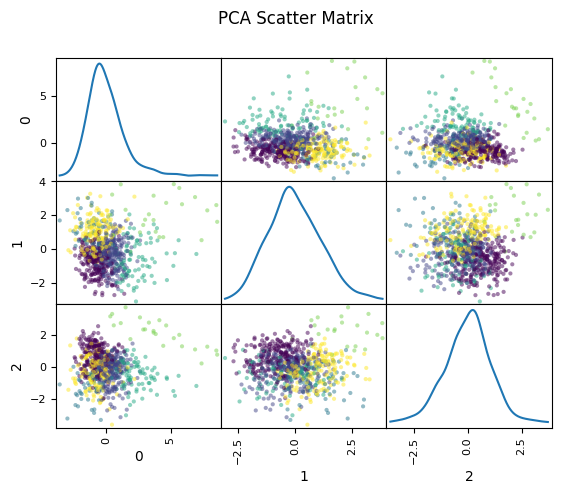

In [35]:
pca = PCA()
scatter_matrix(pd.DataFrame(pca.fit_transform(X)[:,0:3]), c=X_grouped.labels_, diagonal='kde')
plt.suptitle('PCA Scatter Matrix')
plt.show()

Even within the first 3 PCs, there seems to be some overlap. Let's see if we can use the PCA transformed data to obtain clearer results.

In [36]:
np.cumsum(pca.explained_variance_ratio_)

array([0.2533306 , 0.39748636, 0.51365726, 0.62229049, 0.72690685,
       0.81399752, 0.89460206, 0.94927882, 0.97607179, 1.        ])

Taking 7 of the 10 PCs accounts for almost 90% of the variance.

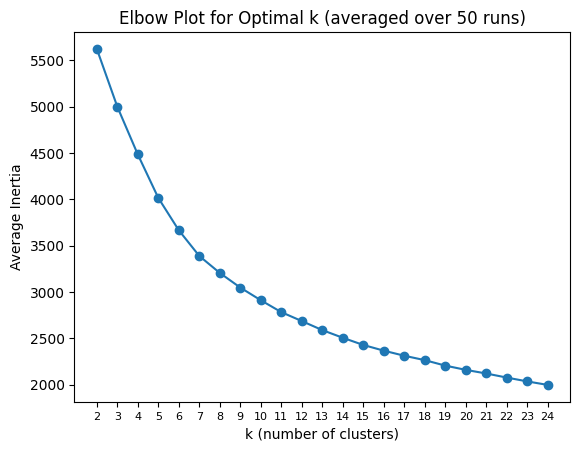

In [37]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
X_pca_grouped = kmeans.fit(X_pca)
elbowPlot(X_pca)

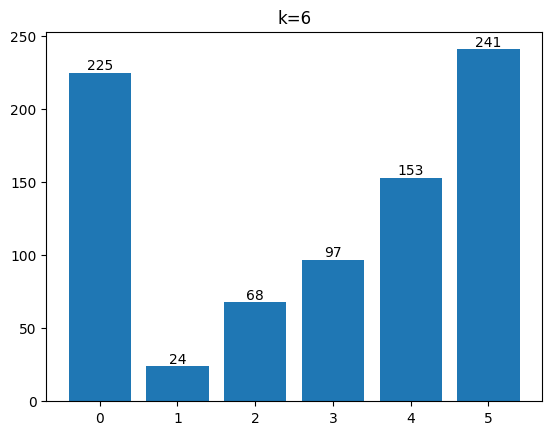

In [41]:
unique, counts = np.unique(X_pca_grouped.labels_, return_counts=True)
clust_groups = plt.bar(unique, counts)
plt.bar_label(clust_groups)
plt.title('k=6')
plt.show()

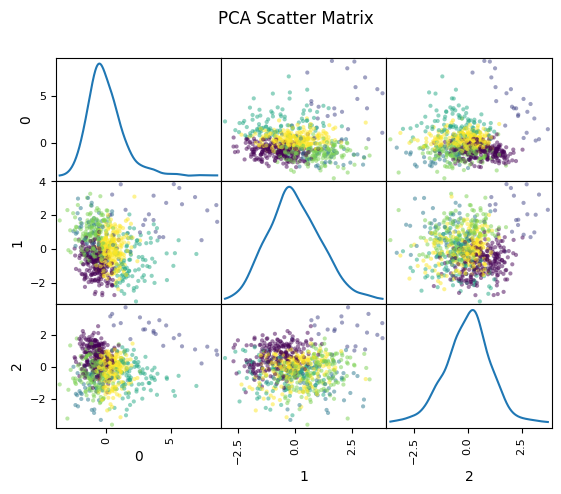

In [42]:
scatter_matrix(pd.DataFrame(X_pca[:,0:3]), c=X_pca_grouped.labels_, diagonal='kde')
plt.suptitle('PCA Scatter Matrix')
plt.show()

The elbow plot, cluster distribution plot, and scatter matrix are extremely similar to the plots from the data before conducting PCA. This means that our principal component analysis did not provide any additional insight.

In [43]:
playlist_grouped_pca = playlist
playlist_grouped_pca['cluster'] = X_pca_grouped.labels_
playlist_grouped.groupby('cluster').mean(numeric_only=True).drop(columns = ['popularity', 'key', 'duration_ms', 'time_signature'])

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,,
0,0.742596,0.730964,-5.666049,0.453333,0.142675,0.142643,0.008431,0.155985,0.670778,113.066489
1,0.448117,0.543592,-10.896833,0.500000,0.046629,0.377484,0.849167,0.139254,0.335187,112.507167
2,0.633206,0.713559,-6.025176,0.588235,0.192153,0.113451,0.014660,0.605015,0.472328,120.243515
3,0.648216,0.450258,-9.229443,0.432990,0.118172,0.533164,0.018859,0.162956,0.411071,112.992113
4,0.573092,0.761353,-5.181941,0.581699,0.214748,0.105119,0.005513,0.181694,0.453338,156.549954
5,0.678963,0.581635,-6.964925,0.485477,0.130932,0.098706,0.006089,0.169680,0.282127,119.400365


In [46]:
playlist_grouped_pca.to_csv('data/playlist_grouped_pca.csv', index=False)

### Model Evaluation

In [401]:
#calculate size of each cluster
cluster_sizes = playlist_grouped['cluster'].value_counts()

#calculate similarity metrics
def calculate_similarity(cluster_df):
    #calculate cosine similarity matrix between songs in the cluster based on features
    cluster_features = cluster_df[['danceability','energy','loudness','mode','speechiness','acousticness',
       'instrumentalness','liveness','valence','tempo']]
    similarity_matrix = cosine_similarity(cluster_features)
    #take the mean of upper triangular matrix (excluding diagonal) to avoid duplicate comparisons
    similarity_score = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=1)].mean()
    return similarity_score

#group by cluster and calculate similarity for each cluster
cluster_similarity = playlist_grouped.groupby('cluster').apply(calculate_similarity, include_groups=False)

#print out the results
print("Cluster Sizes:")
print(cluster_sizes)
print("\nCluster Similarity:")
print(cluster_similarity)

Cluster Sizes:
cluster
0    228
1    227
5    169
3     85
2     75
4     24
Name: count, dtype: int64

Cluster Similarity:
cluster
0    0.999633
1    0.999604
2    0.999484
3    0.998613
4    0.996882
5    0.999829
dtype: float64


Now that we have confirmed that each cluster's internal similarity is high, we can accept our initial results.

### Conclusion

Now for the fun part: let's put together the playlists!